In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path as pt
from loguru import logger
from typing import TypedDict, Literal, Optional, List, Dict, Union, Tuple
import json

In [214]:
root_loc = pt('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/')
base_loc = root_loc / 'ML properties/Analysed/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/'

model = 'lgbm'
embeddings = 'mol2vec_embeddings'
method = 'normal'
pre_trained_filename = f'{model}_{embeddings}_pretrained_model_{method}'
loc = base_loc / f'tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/pretrained_models/{model}/{embeddings}/'
if method != 'normal':
    loc = loc / method

resultsfile = loc / f'{pre_trained_filename}.results.json'
datfile = loc / f'{pre_trained_filename}.dat.json'
learning_curve_file = loc / f'{pre_trained_filename}.learning_curve.json'
print(f'resultsfile exists: {resultsfile.exists()}')
print(f'datfile exists: {datfile.exists()}')
print(f'learning_curve_file exists: {learning_curve_file.exists()}')

resultsfile exists: True
datfile exists: True
learning_curve_file exists: True


In [27]:
# Define the structure of the inner dictionaries
class DataEntry(TypedDict):
    y_true: List[float]
    y_pred: List[float]
    y_linear_fit: List[float]
    
class DataType(TypedDict):
    test: DataEntry
    train: DataEntry


# Define the Embedding type
Embedding = Literal['mol2vec', 'VICGAE']

# Define the MLStats TypedDict
class MLStats(TypedDict):
    r2: float
    mse: float
    rmse: float
    mae: float

# Define the CVScores TypedDict
class CVScores(TypedDict):
    mean: float
    std: float
    ci_lower: float
    ci_upper: float
    scores: List[float]

# Define the CV_scoring_methods type
CV_scoring_methods = Literal['r2', 'mse', 'rmse', 'mae']

# Define the CVScoresData type
CVScoresData = Dict[Literal['test', 'train'], Dict[CV_scoring_methods, CVScores]]

# Define the PlotData and Layout TypedDicts (assuming simplified structures)
class PlotData(TypedDict, total=False):
    x: List[float]
    y: List[float]
    type: str
    name: str

class Layout(TypedDict, total=False):
    title: str
    xaxis: Dict[str, Union[str, int, float]]
    yaxis: Dict[str, Union[str, int, float]]

# Define the MLResults TypedDict
class MLResults(TypedDict):
    learning_curve_plotly_data: Optional[Dict[str, Union[List[PlotData], Layout]]]
    embedding: Embedding
    PCA: bool
    data_shapes: Dict[str, List[int]]
    train_stats: MLStats
    test_stats: MLStats
    model: str
    bootstrap: bool
    bootstrap_nsamples: Optional[int]
    cross_validation: bool
    cv_fold: Optional[int]
    cv_scores: Optional[CVScoresData]
    best_params: Optional[Dict[str, Union[str, int, bool, None]]]
    best_score: Optional[float]
    timestamp: str
    time: str
    

In [28]:
results: MLResults = json.load(open(resultsfile, 'r'))
data: DataType = json.load(open(datfile, 'r'))

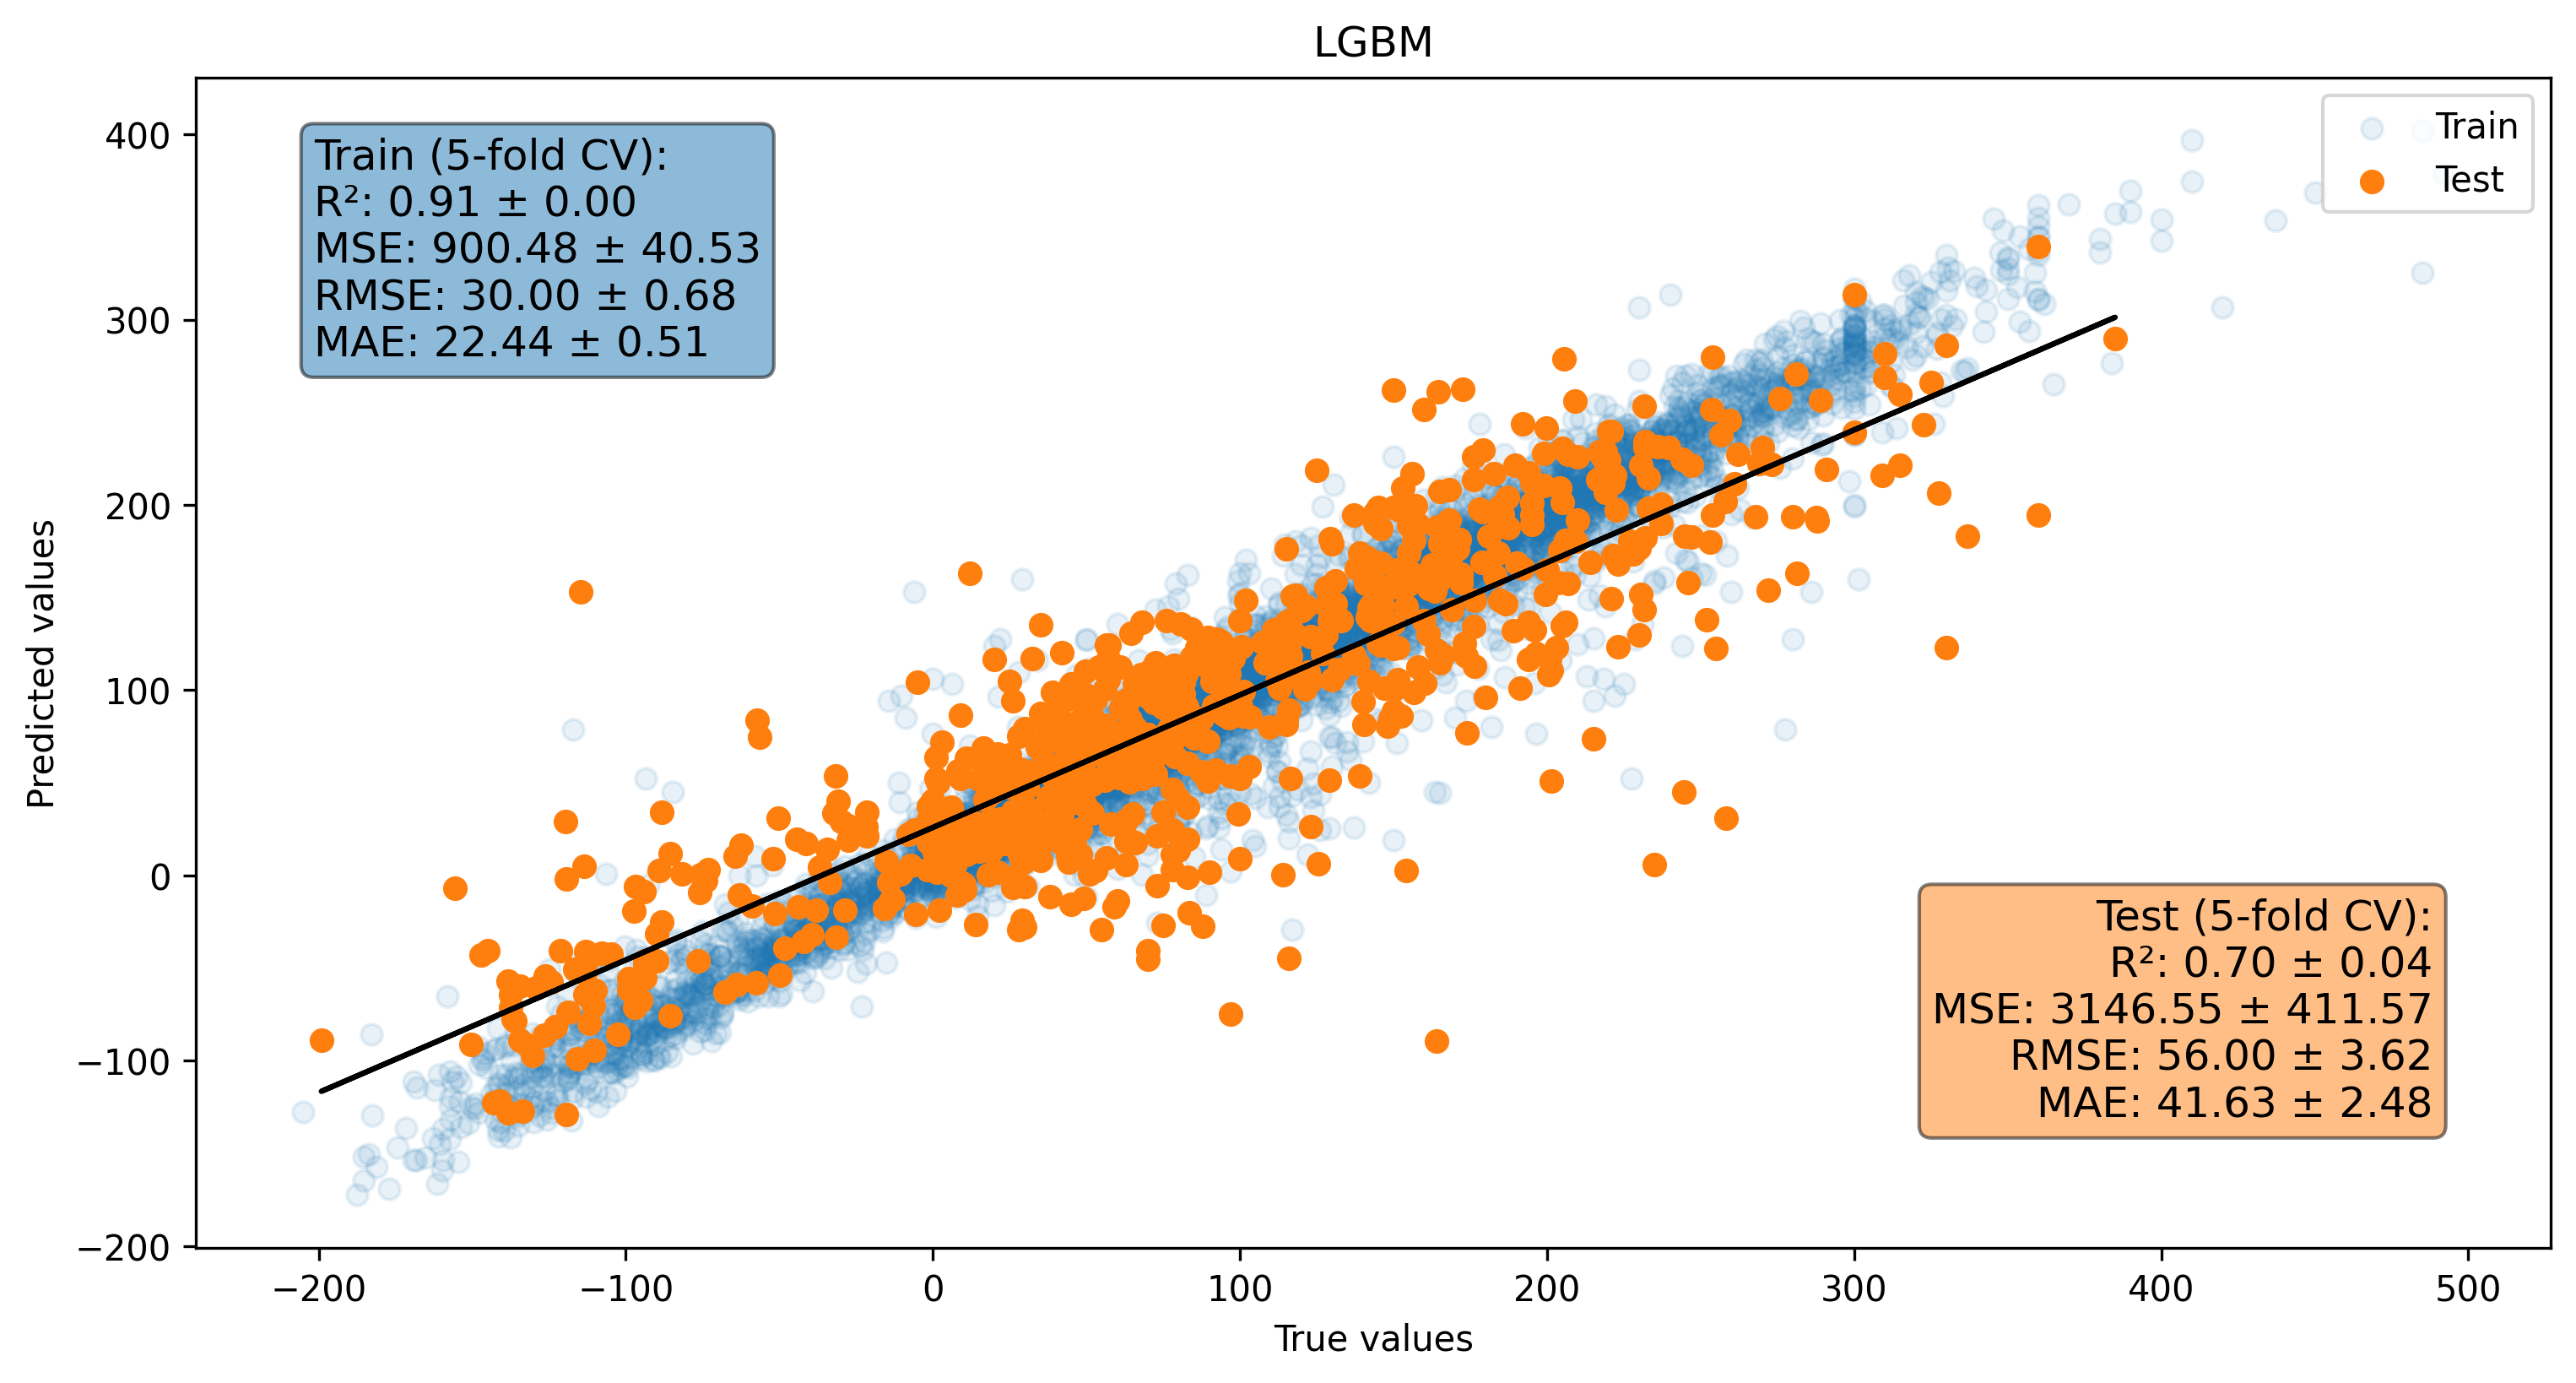

In [89]:
# plot the test and train data with scatter plot
# the fitted line is also plotted
# take rmse, r2, mae, mse from the results and plot them in the title (take it from cv_scores)

# get the data
y_true_test = data["test"]["y_true"]
y_pred_test = data["test"]["y_pred"]
y_linear_fit_test = data["test"]["y_linear_fit"]

y_true_train = data["train"]["y_true"]
y_pred_train = data["train"]["y_pred"]
y_linear_fit_train = data["train"]["y_linear_fit"]


metrics = ["r2", "mse", "rmse", "mae"]
test_scores = {}
train_scores = {}

for v in ["test", "train"]:
    for k in metrics:
        mean = results["cv_scores"][v][k]["mean"]
        std = results["cv_scores"][v][k]["std"]
        if v == "test":
            test_scores[k] = f"{mean:.2f} ± {std:.2f}"
        else:
            train_scores[k] = f"{mean:.2f} ± {std:.2f}"


fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(y_true_train, y_pred_train, color="C0", label="Train", alpha=0.1)
ax.scatter(y_true_test, y_pred_test, color="C1", label="Test")
ax.plot(y_true_test, y_linear_fit_test, color="k")
ax.set_xlabel("True values")
ax.set_ylabel("Predicted values")
ax.legend(loc='upper right')

# Add text annotations for metrics
textstr_train = "\n".join(
    (
        f"Train ({results['cv_fold']}-fold CV):",
        f'R²: {train_scores["r2"]}',
        f'MSE: {train_scores["mse"]}',
        f'RMSE: {train_scores["rmse"]}',
        f'MAE: {train_scores["mae"]}',
    )
)

textstr_test = "\n".join(
    (
        f"Test ({results['cv_fold']}-fold CV):",
        f'R²: {test_scores["r2"]}',
        f'MSE: {test_scores["mse"]}',
        f'RMSE: {test_scores["rmse"]}',
        f'MAE: {test_scores["mae"]}',
    )
)

ax.text(
    0.05,
    0.95,
    textstr_train,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="C0", alpha=0.5),
)
ax.text(
    0.95,
    0.30,
    textstr_test,
    transform=ax.transAxes,
    fontsize=12,
    verticalalignment="top",
    horizontalalignment="right",
    bbox=dict(boxstyle="round", facecolor="C1", alpha=0.5),
)

ax.set_title(model.upper())
fig.set_dpi(300)
plt.show()

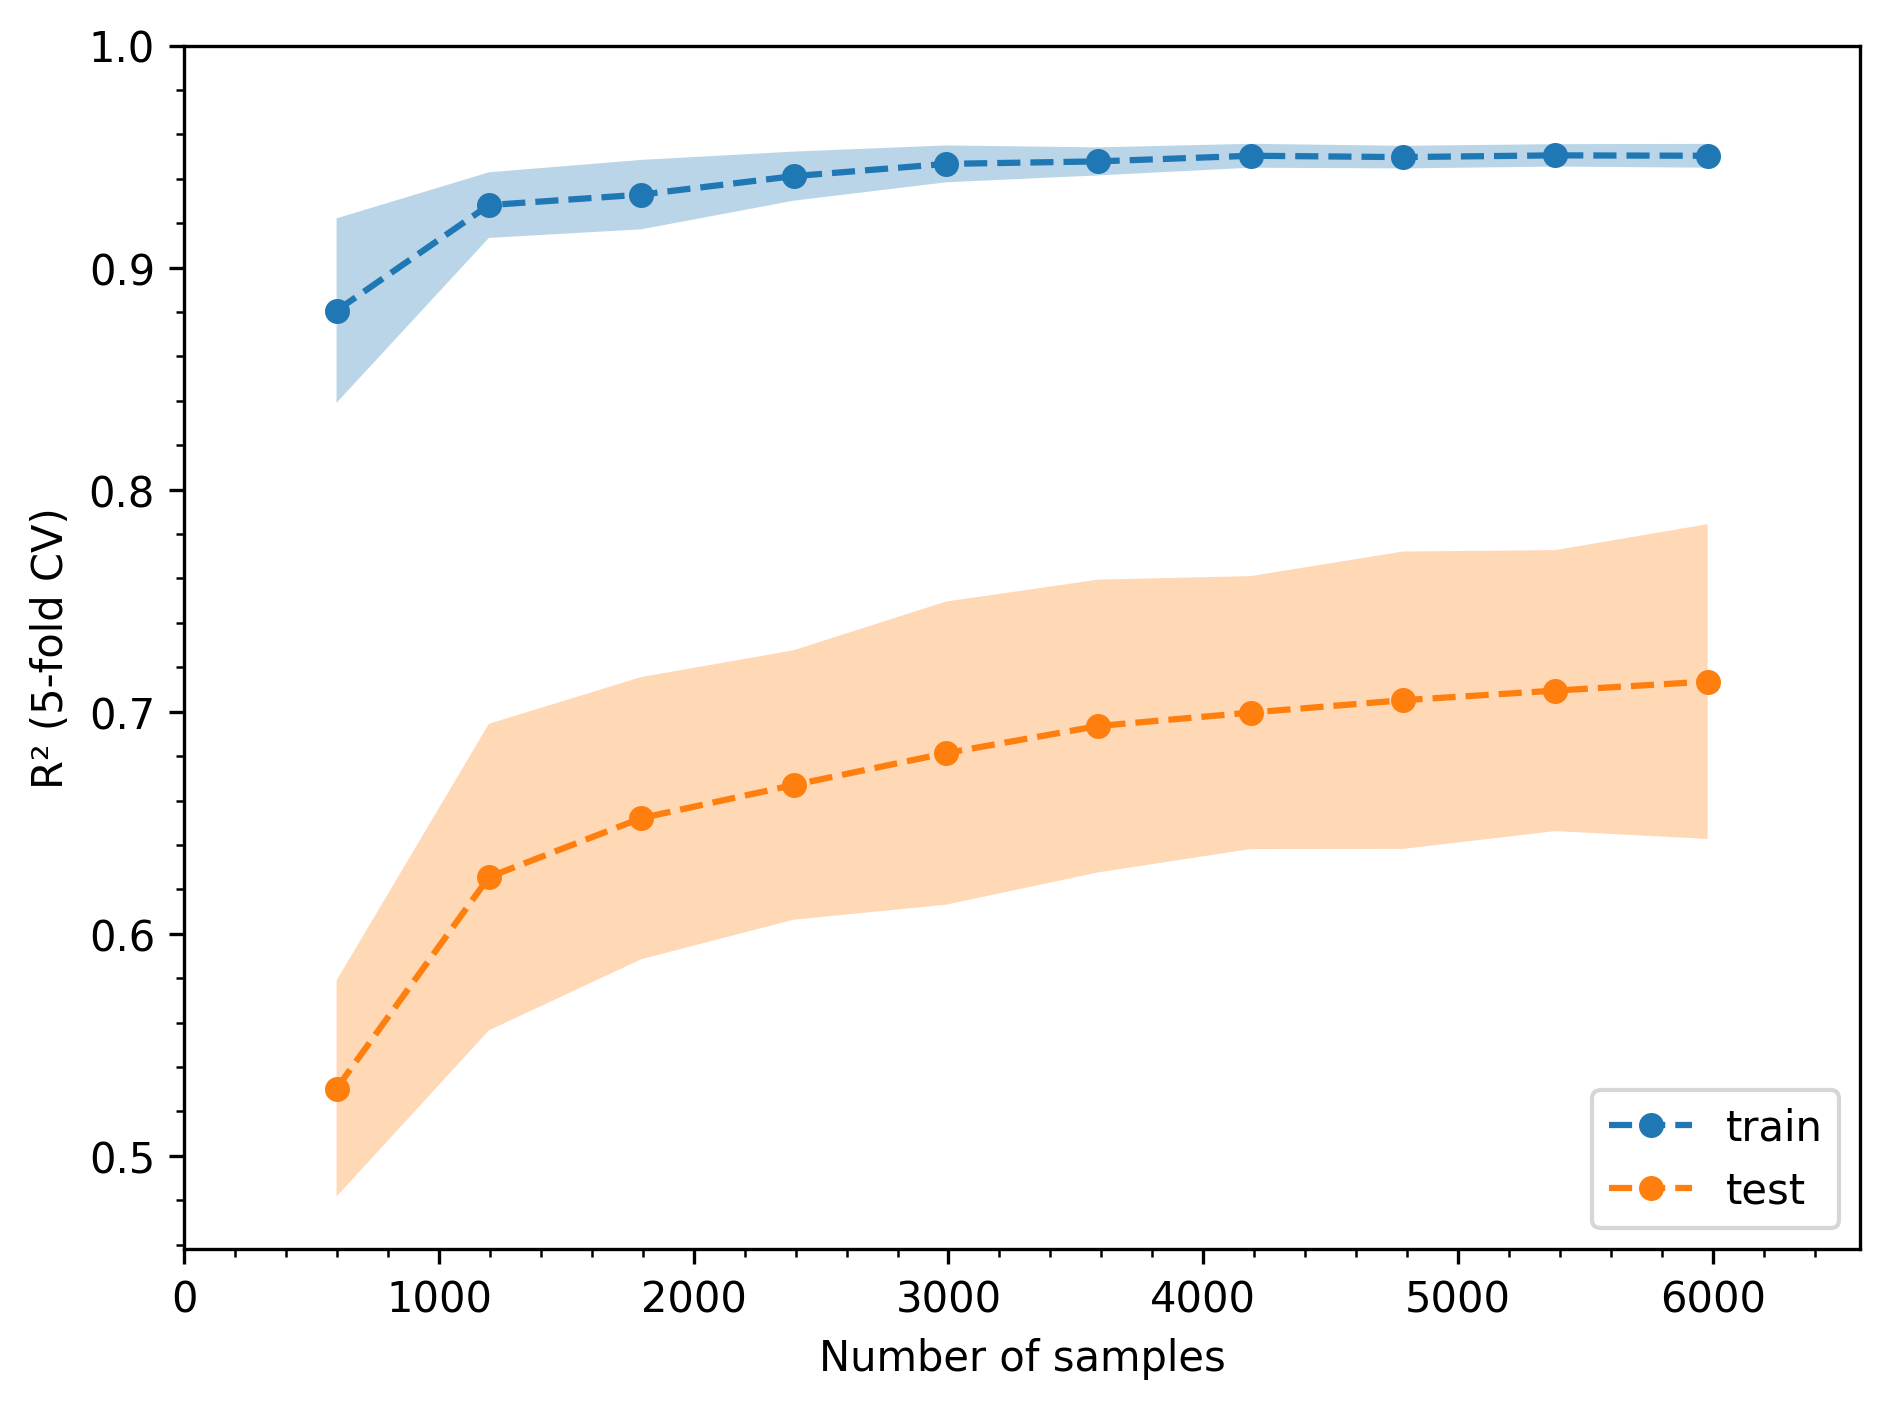

In [224]:
LearningCurveData = Dict[str, Dict[Literal["test", "train"], CVScores]]


class LearningCurve(TypedDict):
    data: LearningCurveData
    train_sizes: List[float]
    sizes: Tuple[float, float, int]
    CV: int
    scoring: Literal["r2"]

learning_curve_file = loc / f'{pre_trained_filename}.learning_curve.json'
learning_curve: LearningCurve = json.load(open(learning_curve_file, 'r'))
learning_curve_data = learning_curve["data"]

# with plt.style.context("seaborn-v0_8-dark"):
    # plot the learning curve
fig, ax = plt.subplots(dpi=300)
train_sizes = learning_curve["train_sizes"]

for t in ["train", "test"]:
    scores = [learning_curve_data[f"{size}"][t]["mean"] for size in train_sizes]
    ci_lower = [learning_curve_data[f"{size}"][t]["ci_lower"] for size in train_sizes]
    ci_upper = [learning_curve_data[f"{size}"][t]["ci_upper"] for size in train_sizes]
    
    ax.plot(train_sizes, scores, '.--', label=t, color="C0" if t == "train" else "C1", ms=10)
    ax.fill_between(train_sizes, ci_lower, ci_upper, alpha=0.3)
    
ax.set_xlabel("Number of samples")
ax.set_ylabel(f"R² ({learning_curve['CV']}-fold CV)")
ax.minorticks_on()
ax.legend()
ax.set_xbound(0, 1.1 * max(train_sizes))
ax.set_ylim(ymax=1)
fig.tight_layout()
fig.savefig(loc / f'{pre_trained_filename}.learning_curve.pdf', dpi=300, bbox_inches='tight')
plt.show()

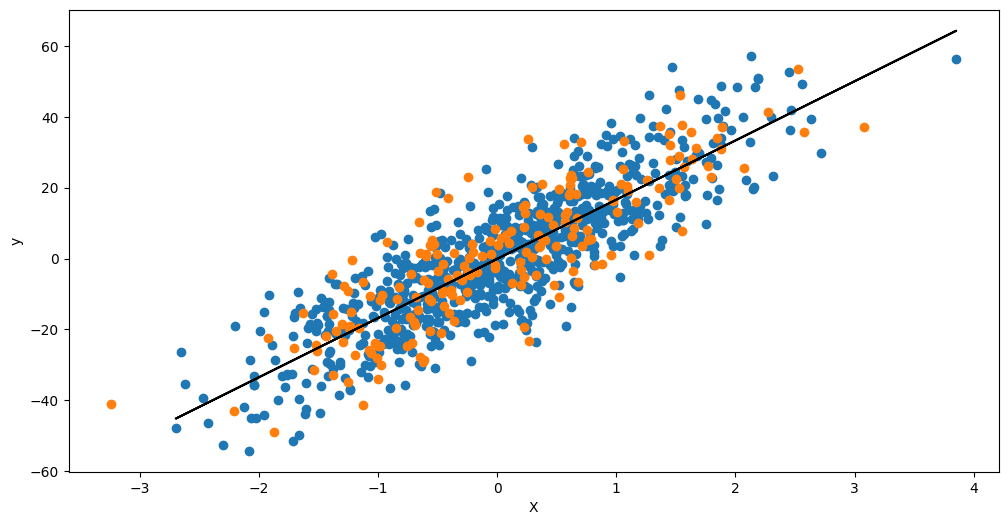

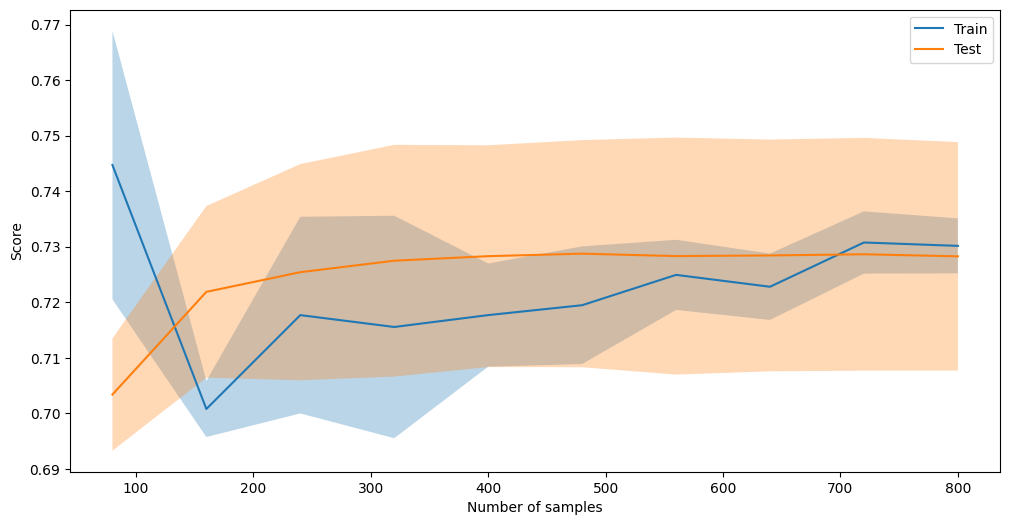

In [98]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=1000, n_features=1, noise=10, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(X_train, y_train, color="C0", label="Train")
ax.scatter(X_test, y_test, color="C1", label="Test")
ax.plot(X_train, y_pred_train, color="k")
ax.set_xlabel("X")
ax.set_ylabel("y")

# learning curve
from sklearn.model_selection import learning_curve

lr_copy = LinearRegression()
train_sizes, train_scores, test_scores = learning_curve(
    lr_copy, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5
)

# plot learning curve
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_sizes, train_scores.mean(axis=1), label="Train")
ax.fill_between(
    train_sizes,
    train_scores.mean(axis=1) - train_scores.std(axis=1),
    train_scores.mean(axis=1) + train_scores.std(axis=1),
    alpha=0.3,
)
ax.plot(train_sizes, test_scores.mean(axis=1), label="Test")
ax.fill_between(
    train_sizes,
    test_scores.mean(axis=1) - test_scores.std(axis=1),
    test_scores.mean(axis=1) + test_scores.std(axis=1),
    alpha=0.3,
)
ax.set_xlabel("Number of samples")
ax.set_ylabel("Score")
ax.legend()
# fig.set_dpi(300)
plt.show()

In [165]:
cv = 12
sizes = (0.1, 1.0, 10)
train_sizes, train_scores, test_scores = learning_curve(
    lr_copy, X, y, train_sizes=np.linspace(*sizes), cv=cv
)

max_train_size_for_cv = int(y.size - y.size / cv)
# max_train_size_for_cv = y.size - y.size // cv
computed_train_sizes = max_train_size_for_cv * np.linspace(*sizes)
computed_train_sizes = computed_train_sizes.astype(int)
train_sizes, max_train_size_for_cv, int(y.size * (1 - 1 / cv)), computed_train_sizes

(array([ 91, 183, 274, 366, 458, 549, 641, 732, 824, 916]),
 916,
 916,
 array([ 91, 183, 274, 366, 458, 549, 641, 732, 824, 916]))

In [166]:
y_len = 7476
sizes = (0.1, 1.0, 10)
cv = 5
max_train_size_for_cv = int(y_len - y_len / cv)
computed_train_sizes = max_train_size_for_cv * np.linspace(*sizes)
computed_train_sizes = computed_train_sizes.astype(int)
computed_train_sizes

array([ 598, 1196, 1794, 2392, 2990, 3588, 4186, 4784, 5382, 5980])

In [212]:
loc

PosixPath('/Users/aravindhnivas/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/ML properties/Analysed/[PHYSICAL CONSTANTS OF ORGANIC COMPOUNDS]/tmp_C_processed_data/analysis_data/filtered/tmpC_topelements_processed_data/pretrained_models/lgbm/mol2vec_embeddings/default')